# Computational Intelligence Coursework - Ali

# Set Up

## Imports

In [1]:
# general imports
import copy
import numpy as np
import pandas as pd
from numba import jit
from matplotlib import pyplot as plt
import csv
import random

# torch & data manipulation imports
import torch
from torch.utils.data import ConcatDataset, Subset, DataLoader
import torchvision
import torchvision.transforms as transforms

# model-related imports
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Helper Function Definitions

In [73]:
from torch.utils.data import Dataset

# DATA PREPROCESSING
class CustomDataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label

# calculate mean & standard deviation based on dataset
def calc_mean_std(dataset):
    dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean_sum = 0.
    var_sum = 0.
    total_images_count = 0
    for images, _ in dataloader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean_sum += images.mean(2).sum(0)
        var_sum += images.var(2).sum(0)
        total_images_count += batch_samples

    mean = mean_sum / total_images_count
    var = var_sum / total_images_count
    std = np.sqrt(var)

    return mean, std

# define transformations for data augmentation
def train_transform(data, mean, std):
  data = normalize(data, mean, std)
  transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(0.25),
                                transforms.RandomVerticalFlip(0.25),
                                transforms.RandomGrayscale(0.25),
                                transforms.RandomCrop(32, padding=4)
                                 ])
  return transform(data)

# define normalisation
def normalize(data, mean, std):
  transform = transforms.Compose([
                                transforms.Normalize(mean, std)
                                ])
  return transform(data)

# Function to freeze all but the last layer
def freeze_all_but_last(model):
    for name, param in model.named_parameters():
        if 'fc3' not in name:
            param.requires_grad = False

## Define Model Architecture

In [3]:
class Net(nn.Module):
    def __init__(self, dropout_prob):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 32, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2, 2)
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Checkpointing

In [4]:
def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)

## Data Loading & Stratification

In [5]:
# load CIFAR-10 dataset & convert to tensor
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True,
                                         transform=transforms.ToTensor())

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True,
                                        transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# dataset hyperparameters
num_folds = 5
test_size = 0.20

# combine train and test datasets for stratified splitting
combined_set = ConcatDataset([train_set, test_set])

# STRATIFIED SPLIT
# collect the labels
labels = [y for _, y in combined_set]

# stratified split subset indices
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))

# subset using indices & collect associated labels
stratified_train_set, stratified_train_labels = Subset(combined_set, train_idx).dataset, [labels[i] for i in range(len(labels)) if i in train_idx]
stratified_test_set, stratified_test_labels = Subset(combined_set, test_idx).dataset, [labels[i] for i in range(len(labels)) if i in test_idx]

# create StratifiedKFold object for train set only
skf = StratifiedKFold(n_splits=num_folds)

# Baselines

## Gradient Based

### Train & Test Function Definitions

In [7]:
# function for training and evaluating the model
def gradient_train_and_validate(model, train_loader, test_loader, criterion, optimizer, mean, std, epochs=30):
    name = "adam" if type(optimizer) == torch.optim.Adam else ("sgd" if type(optimizer) == torch.optim.SGD else "rmsprop")
    model.to(device)
    model.train()

    # early stopping parameters
    early_stopping_patience = 5  # number of epochs to wait for improvement before stopping
    early_stopping_counter = 0    # counter for epochs without improvement
    best_accuracy = 0             # track the best accuracy
    loss_curve = []
    accuracy_curve = []

    # train
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        i = 0

        for inputs, train_load_labels in train_loader:
            inputs = train_transform(inputs, mean, std)
            inputs, train_load_labels = inputs.to(device), train_load_labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, train_load_labels)
            loss.backward()
            optimizer.step()

            loss_curve.append(loss.item())
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += train_load_labels.size(0)
            correct += (predicted == train_load_labels).sum().item()
            accuracy_curve.append(100 * correct / total)
            i += 1
            if i % 20 == 0:
              batch_accuracy = 100 * correct / total
              print(f'Batch {i} Loss: {loss.item():.4f} Batch Accuracy: {batch_accuracy:.4f}')

        epoch_accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{epochs}] Loss: {loss.item():.4f} Epoch Accuracy: {epoch_accuracy:.4f}')

        model.eval()
        correct = 0
        total = 0

        # validate
        with torch.no_grad():
            for inputs, test_load_labels in test_loader:
                inputs = normalize(inputs, mean, std)
                inputs, test_load_labels = inputs.to(device), test_load_labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += test_load_labels.size(0)
                correct += (predicted == test_load_labels).sum().item()

        validation_accuracy = 100 * correct / total

        # check if the current validation accuracy is better than the best recorded accuracy
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            early_stopping_counter = 0  # Reset the counter
            # save the model checkpoint
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, filename=f"models/gd/{name}/checkpoints/best_{name}_epoch_{epoch+1}.pth.tar")
        else:
            early_stopping_counter += 1

        print(early_stopping_counter)
        # check if early stopping should be triggered
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

        print(f'Validation Accuracy: {validation_accuracy:.2f}%')
    return model, loss_curve, accuracy_curve

# function for testing the model
def test(model, test_loader, mean, std):

    model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, test_load_labels in test_loader:
            inputs = normalize(inputs, mean, std)
            inputs, test_load_labels = inputs.to(device), test_load_labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += test_load_labels.size(0)
            correct += (predicted == test_load_labels).sum().item()


    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

### Adam, SGD and RMSprop

In [8]:
# Model hyperparameters
dropout_prob = 0.30
num_epochs = 20
batch_size = 128

model_adam = None
model_sgd = None
model_rmsprop = None
adam_loss = None
adam_accuracy = None
sgd_loss = None
sgd_accuracy = None
rmsprop_loss = None
rmsprop_accuracy = None
# call function
# Main loop for k-fold cross-validation
for fold, (train_fold_indices, val_fold_indices) in enumerate(skf.split(train_idx, stratified_train_labels)):
    print(f'Fold {fold + 1}/{num_folds}')
    mean, std = calc_mean_std(Subset(stratified_train_set, train_fold_indices))

    train_sampler = torch.utils.data.SubsetRandomSampler(train_fold_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_fold_indices)


    train_loader = torch.utils.data.DataLoader(
        dataset=stratified_train_set,
        batch_size=batch_size,
        sampler=train_sampler,
        worker_init_fn=seed_worker,
        generator=g)

    val_loader = torch.utils.data.DataLoader(
        dataset=stratified_train_set,
        batch_size=batch_size,
        sampler=val_sampler,
        worker_init_fn=seed_worker,
        generator=g)

    model_adam = Net(dropout_prob).to(device)
    model_sgd = Net(dropout_prob).to(device)
    model_rmsprop = Net(dropout_prob).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_adam.parameters(), lr=0.001)
    model_adam, adam_loss, adam_accuracy = gradient_train_and_validate(model_adam, train_loader, val_loader, criterion, optimizer, mean, std, epochs=num_epochs)
    optimizer = torch.optim.SGD(model_sgd.parameters(), lr=0.01)    
    model_sgd, sgd_loss, sgd_accuracy = gradient_train_and_validate(model_sgd, train_loader, val_loader, criterion, optimizer, mean, std, epochs=num_epochs)
    optimizer = torch.optim.RMSprop(model_rmsprop.parameters(), lr=0.001)   
    model_rmsprop, rmsprop_loss, rmsprop_accuracy = gradient_train_and_validate(model_rmsprop, train_loader, val_loader, criterion, optimizer, mean, std, epochs=num_epochs)        
    break

Fold 1/5


/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Batch 20 Loss: 2.0534 Batch Accuracy: 19.2578
Batch 40 Loss: 1.9257 Batch Accuracy: 23.2227
Batch 60 Loss: 1.6826 Batch Accuracy: 24.9609
Batch 80 Loss: 1.8055 Batch Accuracy: 27.0410
Batch 100 Loss: 1.5753 Batch Accuracy: 28.6641
Batch 120 Loss: 1.6629 Batch Accuracy: 30.3451
Batch 140 Loss: 1.4623 Batch Accuracy: 31.7522
Batch 160 Loss: 1.4813 Batch Accuracy: 33.1689
Batch 180 Loss: 1.4065 Batch Accuracy: 34.1710
Batch 200 Loss: 1.3763 Batch Accuracy: 35.1289
Batch 220 Loss: 1.4362 Batch Accuracy: 36.2038
Batch 240 Loss: 1.4053 Batch Accuracy: 37.1549
Batch 260 Loss: 1.1962 Batch Accuracy: 38.2181
Batch 280 Loss: 1.3831 Batch Accuracy: 39.1769
Batch 300 Loss: 1.4798 Batch Accuracy: 39.7943
Epoch [1/20] Loss: 1.4798 Epoch Accuracy: 39.7943
0
Validation Accuracy: 52.40%
Batch 20 Loss: 1.7835 Batch Accuracy: 33.7891
Batch 40 Loss: 1.3737 Batch Accuracy: 40.4688
Batch 60 Loss: 1.4456 Batch Accuracy: 42.7995
Batch 80 Loss: 1.4192 Batch Accuracy: 44.0137
Batch 100 Loss: 1.1984 Batch Accura

In [9]:
# test model
test_loader = torch.utils.data.DataLoader(
    dataset=stratified_test_set,
    batch_size=batch_size,
    worker_init_fn=seed_worker,
    generator=g)

print ("Adam:")
test(model_adam, test_loader, mean, std)
print("\nSGD")
test(model_sgd, test_loader, mean, std)
print("\nRMSprop")
test(model_sgd, test_loader, mean, std)

Adam:
Test Accuracy: 84.77%

SGD
Test Accuracy: 76.42%

RMSprop
Test Accuracy: 76.42%


### Adam Run

In [10]:
freeze_all_but_last(model_adam)
# set weights to best individual
params = [random.uniform(-1, 1) for _ in range(3210)]
weights = np.asarray(params, dtype=np.float32)
new_weights = torch.from_numpy(weights[:3200].reshape((10,320))).to(device)
new_biases = torch.from_numpy(weights[3200:3210]).to(device)


model_adam.to(device)
model_adam.train()

# early stopping parameters
early_stopping_patience = 5  # number of epochs to wait for improvement before stopping
early_stopping_counter = 0    # counter for epochs without improvement
best_accuracy = 0             # track the best accuracy
adam_retrain_loss = []
adam_retrain_accuracy = []

for epoch in range(5):
    # train
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0

    for inputs, train_load_labels in train_loader:
        inputs = train_transform(inputs, mean, std)
        inputs, train_load_labels = inputs.to(device), train_load_labels.to(device)
        optimizer.zero_grad()
        outputs = model_adam(inputs)
        loss = criterion(outputs, train_load_labels)
        loss.backward()
        optimizer.step()

        adam_retrain_loss.append(loss.item())
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += train_load_labels.size(0)
        correct += (predicted == train_load_labels).sum().item()
        adam_retrain_accuracy.append(100 * correct / total)
        i += 1
        if i % 20 == 0:
            batch_accuracy = 100 * correct / total
            print(f'Batch {i} Loss: {loss.item():.4f} Batch Accuracy: {batch_accuracy:.4f}')

    epoch_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1} Loss: {loss.item():.4f} Epoch Accuracy: {epoch_accuracy:.4f}')

    model_adam.eval()
    correct = 0
    total = 0

    # validate
    with torch.no_grad():
        for inputs, test_load_labels in test_loader:
            inputs = normalize(inputs, mean, std)
            inputs, test_load_labels = inputs.to(device), test_load_labels.to(device)
            outputs = model_adam(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += test_load_labels.size(0)
            correct += (predicted == test_load_labels).sum().item()

    validation_accuracy = 100 * correct / total

    # check if the current validation accuracy is better than the best recorded accuracy
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        early_stopping_counter = 0  # Reset the counter
        # save the model checkpoint
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model_adam.state_dict(),
            'optimizer': optimizer.state_dict(),
        }, filename=f"models/gd/adam/checkpoints/best_adam_retrain_epoch_{epoch+1}.pth.tar")
    else:
        early_stopping_counter += 1

    print(f'Validation Accuracy: {validation_accuracy:.2f}%')


Batch 20 Loss: 1.6802 Batch Accuracy: 41.6016
Batch 40 Loss: 1.6245 Batch Accuracy: 41.0742
Batch 60 Loss: 1.5365 Batch Accuracy: 41.2240
Batch 80 Loss: 1.5738 Batch Accuracy: 41.4355
Batch 100 Loss: 1.4200 Batch Accuracy: 41.2266
Batch 120 Loss: 1.5651 Batch Accuracy: 41.0612
Batch 140 Loss: 1.6383 Batch Accuracy: 41.0714
Batch 160 Loss: 1.6746 Batch Accuracy: 41.0498
Batch 180 Loss: 1.7187 Batch Accuracy: 41.2760
Batch 200 Loss: 1.5355 Batch Accuracy: 41.3828
Batch 220 Loss: 1.7449 Batch Accuracy: 41.2571
Batch 240 Loss: 1.8609 Batch Accuracy: 41.3607
Batch 260 Loss: 1.6790 Batch Accuracy: 41.3281
Batch 280 Loss: 1.7466 Batch Accuracy: 41.2612
Batch 300 Loss: 1.5289 Batch Accuracy: 41.2786
Epoch 1 Loss: 1.5289 Epoch Accuracy: 41.2786
Validation Accuracy: 51.74%
Batch 20 Loss: 1.5070 Batch Accuracy: 46.5234
Batch 40 Loss: 1.5688 Batch Accuracy: 46.8750
Batch 60 Loss: 1.6718 Batch Accuracy: 47.1484
Batch 80 Loss: 1.5278 Batch Accuracy: 46.8262
Batch 100 Loss: 1.5968 Batch Accuracy: 46.

In [11]:
print ("Adam Retrained:")
test(model_adam, test_loader, mean, std)

Adam Retrained:
Test Accuracy: 51.74%


In [74]:
adam_retrain_loss[-1]

1.5207455158233643

### Save Loss & Accuracy Curves

In [12]:
adam_stats = {"loss": adam_loss, "accuracy": adam_accuracy}
adam_retrain_stats = {"loss": adam_retrain_loss, "accuracy": adam_retrain_accuracy}
sgd_stats = {"loss": sgd_loss, "accuracy": sgd_accuracy}
rmsprop_stats = {"loss": rmsprop_loss, "accuracy": rmsprop_accuracy}

df_adam = pd.DataFrame(adam_stats)
df_adam_retrain = pd.DataFrame(adam_retrain_stats)
df_sgd = pd.DataFrame(sgd_stats)
df_rmsprop = pd.DataFrame(rmsprop_stats)

df_adam.to_csv('models/gd/adam/stats/loss_acc.csv', index=False, header=False )
df_adam.to_csv('models/gd/adam/stats/retrain_loss_acc')
df_sgd.to_csv('models/gd/sgd/stats/loss_acc.csv', index=False, header=False )
df_rmsprop.to_csv('models/gd/rmsprop/stats/loss_acc.csv', index=False, header=False )

### Plots

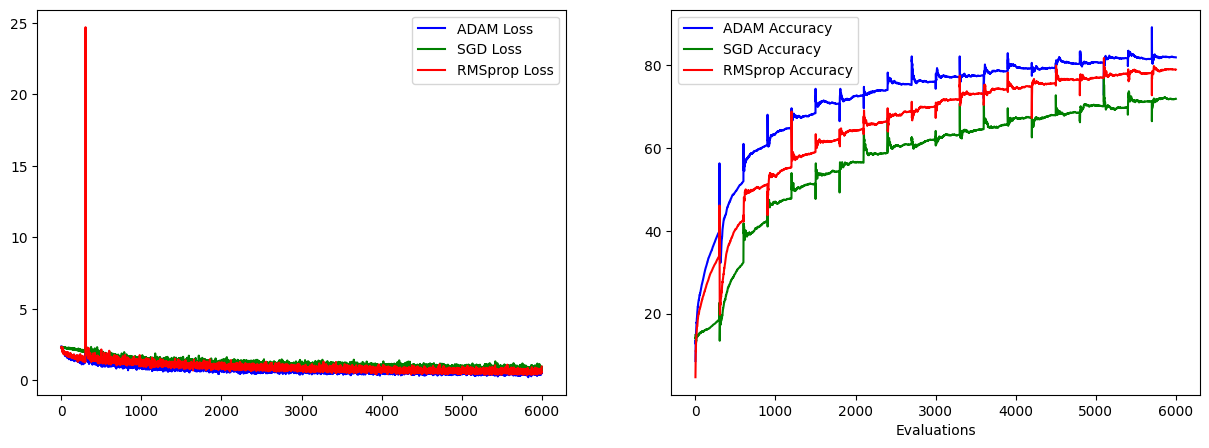

In [13]:
gd_fig = plt.figure(figsize=(15,5))

# First subplot
loss = gd_fig.add_subplot(121)

# Second subplot
acc = gd_fig.add_subplot(122)

# Example data
epochs = list(range(1, 6001))  # Replace with your actual x-axis values

# Plotting
acc.plot(epochs, adam_accuracy, color='blue', linestyle='-', label='ADAM Accuracy')
loss.plot(epochs, adam_loss, color='blue', linestyle='-', label='ADAM Loss')
acc.plot(epochs, sgd_accuracy, color='green', linestyle='-', label='SGD Accuracy')
loss.plot(epochs, sgd_loss, color='green', linestyle='-', label='SGD Loss')
acc.plot(epochs, rmsprop_accuracy, color='red', linestyle='-', label='RMSprop Accuracy')
loss.plot(epochs, rmsprop_loss, color='red', linestyle='-', label='RMSprop Loss')

# Labeling Axes
plt.xlabel('Evaluations')
plt.xlabel('Evaluations')

# Adding a Legend
acc.legend()
loss.legend()

# Show the plot
plt.show()

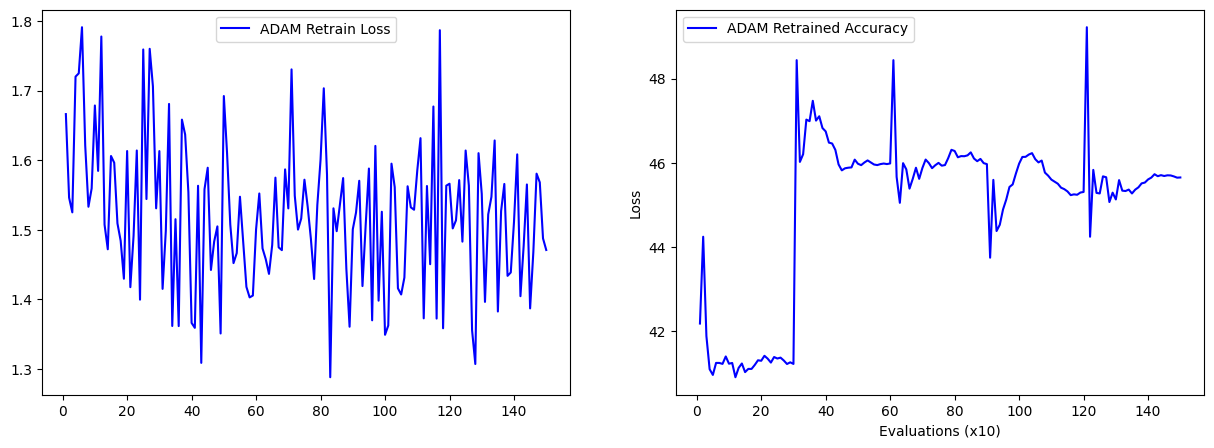

In [14]:
adam_fig = plt.figure(figsize=(15,5))

# First subplot
retrain_loss = adam_fig.add_subplot(121)

# Second subplot
retrain_acc = adam_fig.add_subplot(122)

# Example data
epochs = list(range(1, 151))  # Replace with your actual x-axis values

retrain_acc.plot(epochs, adam_retrain_accuracy[::10], color='blue', linestyle='-', label='ADAM Retrained Accuracy')
retrain_loss.plot(epochs, adam_retrain_loss[::10], color='blue', linestyle='-', label='ADAM Retrain Loss')

# Labeling Axes
plt.xlabel('Evaluations (x10)')
plt.ylabel('Loss')

# Adding a Legend
retrain_acc.legend()
retrain_loss.legend()

# Show the plot
plt.show()

## Population Based - Genetic Algorithm

### Imports

In [15]:
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from sympy.combinatorics.graycode import bin_to_gray
from deap import creator, base, tools, benchmarks, algorithms
from numpy import genfromtxt

### Helper Function Definitions

In [21]:
best_checkpoint = torch.load("models/gd/adam/checkpoints/best_adam_epoch_20.pth.tar")  # Replace X with the epoch number
model_GA = Net(dropout_prob)
model_GA.load_state_dict(best_checkpoint['state_dict'])

<All keys matched successfully>

In [17]:


popSize     = 100 #Population size
numOfBits   = 30 #Number of bits in the chromosomes
iterations  = 100 #Number of generations to be run
dspInterval = 5
nElitists   = 10 #number of elite individuals selected
crossProb   = 0.8
mutateprob  = .95 #mutation prob
maxnum      = 2.0**numOfBits #absolute max size of number coded by binary list 1,0,0,1,1,....
l = 20 #weight limit

fc3_weights = model_GA.fc3.weight.data
weights_dim = fc3_weights.shape
weights_len = len(fc3_weights.reshape(-1))
fc3_bias = model_GA.fc3.bias.data
bias_dim = fc3_bias.shape
bias_len = len(fc3_bias.reshape(-1))
populationSize  = 100
dimension = weights_len + bias_len

Chrom_length=dimension
print(Chrom_length)
flipProb    = 1. / (Chrom_length * numOfBits/30) #bit mutate prob

toolbox_GA = base.Toolbox()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_GA.parameters(), lr=0.001)

def calcFitness(individual, model, inputs, labels):
    weights=separatevariables(individual)
    weights = np.asarray(weights, dtype=np.float32)


    new_weights = torch.from_numpy(weights[:weights_len].reshape(weights_dim))
    new_biases = torch.from_numpy(weights[weights_len:dimension])
    new_weights = new_weights.to(device)
    new_biases = new_biases.to(device)
    model_GA.fc3.weight = torch.nn.Parameter(new_weights)
    model_GA.fc3.bias = torch.nn.Parameter(new_biases)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    inputs, labels = torch.FloatTensor(inputs), torch.Tensor(labels)
    inputs, labels, model = inputs.to(device), labels.to(device), model.to(device)
    optimizer.zero_grad()  # clear gradients for next train

    # fitness
    outputs = model(inputs)  # input and predict based on images
    loss = criterion(outputs, labels)
    return loss.item(),

#----------

# Convert chromosome to real number
# input: list binary 1,0 of length numOfBits representing number using gray coding
# output: real value
def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    numinrange=-1.0+2.0*numasint/maxnum
    return numinrange*20

def real2chrom(weight):
    #print("in real2chrom ",weight)
    weight=weight/20
    if weight<-1:
        weight=-1
    if weight>1:
        weight=1
    integerPart = int(maxnum * (weight + 1) / 2)
    if (integerPart == maxnum):
        integerPart -= 1
    chromosome = [int(d) for d in str(bin(integerPart))[2:]]
    while (len(chromosome) < numOfBits):
        chromosome.insert(0,0)
    indasstring=''.join(map(str, chromosome))
    chromosome=bin_to_gray(indasstring)
    output=[]
    for digit in chromosome:
        output.append(int(digit))
    #print("out",chrom2real(chromosome))
#     print(chromosome)
#     if False in chromosome:
#         print ("got false")
    return output

def separatevariables(v):
#     print(v)
    sep = []
    for i in range (0,numOfBits*(Chrom_length),numOfBits):
        sep.append(chrom2real(v[i:i+numOfBits]))
    return sep

330


### GA Logic

In [18]:
def GA_optimise(model, toolbox_GA, pop, inputs, labels, g, loss_values):
    #random.seed(64)

    if g == 1:
        # create an initial population of individuals (where
        # each individual is a list of integers)
        popa = copy.deepcopy(pop)
        #scale weights down
        pop=[]
        for ind in popa:
            sep=separatevariables(ind)
            weightlist=[]
            for weight in sep:
                weightlist+=real2chrom(weight)#/20)
            #print(weightlist)
            pop.append(creator.Individual(weightlist))
    
        # Evaluate the entire population
        fitnesses = [toolbox_GA.evaluate(individual, model, inputs, labels) for individual in pop]
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        
        print("  Evaluated %i individuals" % len(pop))

    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]
    

    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = tools.selBest(pop, nElitists) 
    #print("elite:",offspring[0].fitness.values[0])
    offspring+= toolbox_GA.select(pop,len(pop)-nElitists,2)

    # Clone the selected individuals
    offspring = list(map(toolbox_GA.clone, offspring))

    # Apply crossover and mutation on the offspring
    # make pairs of offspring for crossing over
    for child1, child2 in zip(offspring[9::2], offspring[10::2]):

        # cross two individuals with probability CXPB
        if random.random() < crossProb:
            #print('before crossover ',child1, child2)
            toolbox_GA.mate(child1, child2)
            #print('after crossover ',child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring[9::]:

        # mutate an individual with probability mutateprob
        if random.random() < mutateprob:
            toolbox_GA.mutate(mutant)
            del mutant.fitness.values

    pop[:] = offspring
    fitnesses = [toolbox_GA.evaluate(individual, model, inputs, labels) for individual in pop]
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    #m = sum(ind.fitness.values[0] for ind in pop)/popSize
    fits = [ind.fitness.values[0] for ind in pop]
    loss_values.append(min(fits)) 

    # The population is entirely replaced by the offspring

    if g%dspInterval ==0:
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        

        print("  Min %s" % min(fits))
        print("  Max %s" % np.max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
    
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    #print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))
#     print("Decoded x is %s" % (separatevariables(best_ind)))
    #print("Fitness %s" % (calcFitness(best_ind, model, inputs, labels)))

    weights = np.asarray(separatevariables(best_ind), dtype=np.float32)
    new_weights = torch.from_numpy(weights[:weights_len].reshape(weights_dim)).to(device)
    new_biases = torch.from_numpy(weights[weights_len:dimension]).to(device)

    return new_weights, new_biases, pop 

### Train Logic

In [19]:
# function for training and evaluating the model
def GA_train_and_validate(model, toolbox, pop, train_loader, test_loader, criterion, optimizer, mean, std, fits, epochs=30):
    model.to(device)
    model.train() # turn off dropout layers

    # early stopping parameters
    early_stopping_patience = 3  # number of epochs to wait for improvement before stopping
    early_stopping_counter = 0    # counter for epochs without improvement
    best_accuracy = 0             # track the best accuracy
    loss_curve = []  # track loss curve
    accuracy_curve = []  # track accuracy curve

    # train
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        i = 0

        for inputs, train_load_labels in train_loader:
            inputs = train_transform(inputs, mean, std)
            #inputs, train_load_labels = inputs.to(device), train_load_labels.to(device)
            i += 1
            new_weights, new_biases, pop = GA_optimise(model, toolbox, pop, inputs, train_load_labels, i, fits)
            model.fc3.weight = torch.nn.Parameter(new_weights)
            model.fc3.biases = torch.nn.Parameter(new_biases)
            inputs, train_load_labels = inputs.to(device), train_load_labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, train_load_labels)
            loss_curve.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item()
            total += train_load_labels.size(0)
            correct += (predicted == train_load_labels).sum().item()
            #if i % 20 == 0:
            batch_accuracy = 100 * correct / total
            accuracy_curve.append(batch_accuracy)
            print(f'{i}th Batch Loss: {loss.item():.4f} Batch Accuracy: {batch_accuracy:.4f}')

        epoch_accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{epochs}] Loss: {loss.item():.4f} Epoch Accuracy: {epoch_accuracy:.4f}')

        model.eval()
        correct = 0
        total = 0

        # validate
        with torch.no_grad():
            for inputs, test_load_labels in test_loader:
                #inputs = normalize(inputs, mean, std)
                inputs, test_load_labels = inputs.to(device), test_load_labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += test_load_labels.size(0)
                correct += (predicted == test_load_labels).sum().item()

        validation_accuracy = 100 * correct / total

        # check if the current validation accuracy is better than the best recorded accuracy
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            early_stopping_counter = 0  # Reset the counter
            # save the model checkpoint
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, filename=f"best_GA_epoch_{epoch+1}.pth.tar")
        else:
            early_stopping_counter += 1

        print(early_stopping_counter)
        # check if early stopping should be triggered
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

        print(f'Validation Accuracy: {validation_accuracy:.2f}%')
    return model, loss_curve, accuracy_curve

### Train & Test Model


In [22]:
# Freeze all layers except the last
freeze_all_but_last(model_GA)

if "Individual" in dir(creator) or "FitnessMin" in dir(creator):
    del creator.Individual, creator.FitnessMin


# DEAP inits
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox_GA = base.Toolbox()

# Attribute generator 
#                      define 'attr_bool' to be an attribute ('gene')
#                      which corresponds to integers sampled uniformly
#                      from the range [0,1] (i.e. 0 or 1 with equal
#                      probability)
toolbox_GA.register("attr_bool", random.randint, 0, 1)

# Structure initializers
#                         define 'individual' to be an individual
#                         consisting of numOfBits*dimension 'attr_bool' elements ('genes')
toolbox_GA.register("individual", tools.initRepeat, creator.Individual, 
    toolbox_GA.attr_bool, numOfBits*(Chrom_length))

# define the population to be a list of individuals
toolbox_GA.register("population", tools.initRepeat, list, toolbox_GA.individual)

#----------
# Operator registration
#----------
# register the goal / fitness function
toolbox_GA.register("evaluate", calcFitness)

# register the crossover operator
toolbox_GA.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox_GA.register("mutate", tools.mutFlipBit, indpb=flipProb)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox_GA.register("select", tools.selTournament, fit_attr='fitness')

# Model hyperparameters
dropout_prob = 0.30
num_epochs = 1
batch_size = 128

ga_loss = None
ga_accuracy = None
fits_GA = []

# call function
# Main loop for k-fold cross-validation
for fold, (train_fold_indices, val_fold_indices) in enumerate(skf.split(train_idx, stratified_train_labels)):
    print(f'Fold {fold + 1}/{num_folds}')
    mean, std = calc_mean_std(Subset(stratified_train_set, train_fold_indices))

    train_sampler = torch.utils.data.SubsetRandomSampler(train_fold_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_fold_indices)

    # create an initial population of individuals
    pop = toolbox_GA.population(n=populationSize)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)


    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    train_loader = torch.utils.data.DataLoader(
        dataset=stratified_train_set,
        batch_size=batch_size,
        sampler=train_sampler,
        worker_init_fn=seed_worker,
        generator=g)

    val_loader = torch.utils.data.DataLoader(
        dataset=stratified_train_set,
        batch_size=batch_size,
        sampler=val_sampler,
        worker_init_fn=seed_worker,
        generator=g)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_GA.parameters(), lr=0.001)

    model_GA, ga_loss, ga_accuracy = GA_train_and_validate(model_GA, toolbox_GA, pop, train_loader, val_loader, criterion, optimizer, mean, std, fits_GA, epochs=5)
    break

Fold 1/5


/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


  Evaluated 100 individuals
-- Generation 1 --
-- End of (successful) evolution --
1th Batch Loss: 91.6561 Batch Accuracy: 10.9375
-- Generation 2 --
-- End of (successful) evolution --
2th Batch Loss: 94.4980 Batch Accuracy: 12.1094
-- Generation 3 --
-- End of (successful) evolution --
3th Batch Loss: 80.0912 Batch Accuracy: 11.9792
-- Generation 4 --
-- End of (successful) evolution --
4th Batch Loss: 69.6968 Batch Accuracy: 13.8672
-- Generation 5 --
  Min 67.35565185546875
  Max 171.85842895507812
  Avg 102.572953414917
  Std 20.99040837297664
-- End of (successful) evolution --
5th Batch Loss: 67.6491 Batch Accuracy: 13.2812
-- Generation 6 --
-- End of (successful) evolution --
6th Batch Loss: 66.7951 Batch Accuracy: 13.0208
-- Generation 7 --
-- End of (successful) evolution --
7th Batch Loss: 67.2889 Batch Accuracy: 13.6161
-- Generation 8 --
-- End of (successful) evolution --
8th Batch Loss: 61.6448 Batch Accuracy: 14.0625
-- Generation 9 --
-- End of (successful) evolution 

In [ ]:
print ("GA:")
test(model_GA, test_loader, mean, std)

GA:
Test Accuracy: 60.13%


### Save Loss, Accuracy & Fitness Curves

In [23]:
ga_stats = {"loss": ga_loss, "accuracy": ga_accuracy, "fits": fits_GA}

df_GA = pd.DataFrame(ga_stats)

df_GA.to_csv('models/gd/adam/stats/loss_acc.csv', index=False, header=False )

### Save DEAP Population & Toolbox

In [24]:
# save population to csv
with open('models/pop/ga/deap/population.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for individual in pop:
        writer.writerow(individual)  # Write the individual's attributes

In [25]:
with open('models/pop/ga/deap/logbook.csv', 'w', newline='') as csvfile:
    # If logbook entries are dictionaries, get the keys for column headers
    if logbook:
        headers = list(logbook[0].keys())
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()
        for entry in logbook:
            writer.writerow(entry)

### Plots

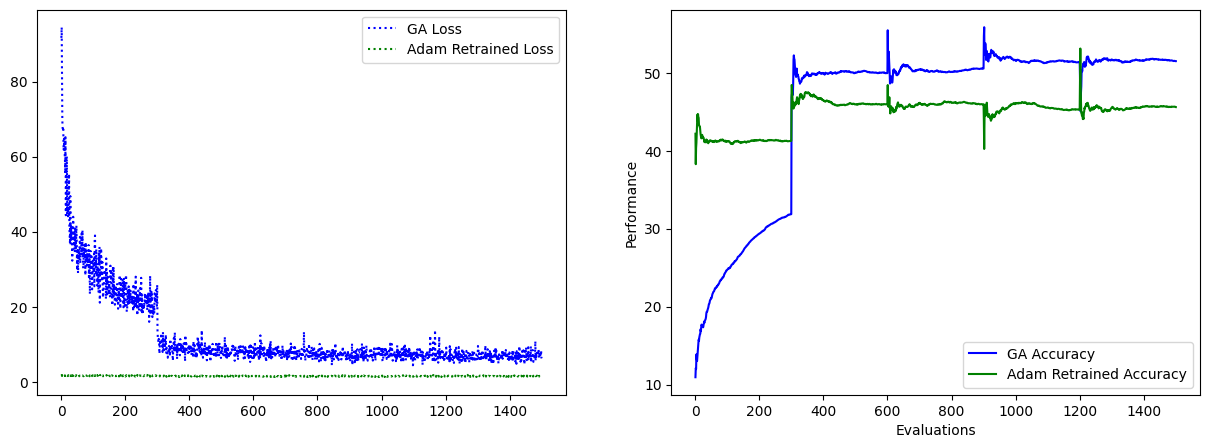

In [26]:
ga_fig = plt.figure(figsize=(15,5))

# First subplot
loss_plot_ga = ga_fig.add_subplot(121)

# Second subplot
acc_plot_ga = ga_fig.add_subplot(122)

# Example data
epochs = list(range(1, 1501))  # Replace with your actual x-axis values

# Plotting
acc_plot_ga.plot(epochs, ga_accuracy, color='blue', linestyle='-', label='GA Accuracy')
acc_plot_ga.plot(epochs, adam_retrain_accuracy, color='green', linestyle='-', label='Adam Retrained Accuracy')
loss_plot_ga.plot(epochs, ga_loss, color='blue', linestyle=':', label='GA Loss')
loss_plot_ga.plot(epochs, adam_retrain_loss, color='green', linestyle=':', label='Adam Retrained Loss')

# Labeling Axes
plt.xlabel('Evaluations')
plt.ylabel('Performance')

# Adding a Legend
acc_plot_ga.legend()
loss_plot_ga.legend()

# Show the plot
plt.show()

# Hybrid Adaptive Memetic Swarms

### Imports

In [28]:
import operator
import math

### Helper Function Defintiions

In [38]:
def neighbour_search(pop, individual, neighbours=10):
    distances = {}
    for i, part in enumerate(pop):
        # print(f"part: {len(part)} individual: {len(individual)}")
        if individual != part:
            distance = np.linalg.norm(np.array(part)-np.array(individual))
            if len(distances) < neighbours:
                distances[i] = distance
            else:
                copy = distances.copy()
                for e in copy.keys():
                    if distances[e] > distance:
                        distances[i] = distance
                        del distances[e]
                        break
    neighbourhood = [pop[i] for i in distances.keys()]
    sort_population(neighbourhood, potential=True)
    return neighbourhood

def sort_population(population, potential=False):
    if potential:
        population.sort(key=lambda x: x.potential[0])
    else:
        population.sort(key=lambda x: x.fitness.values[0])

In [39]:
@jit(cache=True)
def generate_particle(dimension):
    part = creator.Particle([random.uniform(-1, 1) for _ in range(dimension)])
    part.speed = [random.uniform(-1, 1) for _ in range(dimension)]
    part.smin = -1
    part.smax = 1
    return part

# Define the fitness function
def evaluate_particle(model, particle, inputs, labels, best=False):
    weights = np.asarray(particle, dtype=np.float32)
    new_weights = torch.from_numpy(weights[:weights_len].reshape(weights_dim))
    new_biases = torch.from_numpy(weights[weights_len:dimension])
    new_weights = new_weights.to(device)
    new_biases = new_biases.to(device)
    model.fc3.weight = torch.nn.Parameter(new_weights)
    model.fc3.bias = torch.nn.Parameter(new_biases)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    inputs, labels = torch.FloatTensor(inputs), torch.Tensor(labels)
    inputs, labels, model = inputs.to(device), labels.to(device), model.to(device)
    optimizer.zero_grad()  # clear gradients for next train

    # fitness
    outputs = model(inputs)  # input and predict based on images
    loss = criterion(outputs, labels)
    fitness = loss.item(),

    # potential
    loss.backward()  # backpropagation, compute gradients
    optimizer.step()  # apply gradients
    optimizer.zero_grad()  # clear gradients for next train
    outputs = model(inputs)  # input and predict based on images
    loss = criterion(outputs, labels)
    potential = loss.item(),

    if best:
            # potential turns into fitness
            fitness = potential

            # and next gradient descent becomes the potential
            loss.backward()  # backpropagation, compute gradients
            optimizer.step()  # apply gradients
            optimizer.zero_grad()  # clear gradients for next train
            outputs = model(inputs)  # input and predict based on images
            loss = criterion(outputs, labels)
            potential = loss.item(),

            demonstrator_weights = model.fc3.weight.data.to('cpu').reshape(-1)
            demonstrator_biases = model.fc3.bias.data.to('cpu').reshape(-1)
            new_lamarckian = np.concatenate((demonstrator_weights, demonstrator_biases))
            new_speed = new_lamarckian - weights
            new_particle = creator.Particle(new_lamarckian)
            new_particle.speed = new_speed
            new_particle.fitness.values = fitness
            new_particle.potential = potential
            
            return new_particle
    else:
            particle.fitness.values = fitness
            particle.potential = potential
    #return loss.item(),

# social learning in a neighbourhood of size
def behaviour_learning(model, inputs, labels, gamma, gbest, part, pop, epsilon, neighbours=10):

    i = pop.index(part)
    neighbour_pop = neighbour_search(pop, part, neighbours)
    mu = np.mean(np.asarray(neighbour_pop, dtype=np.float32), axis=0)

    index = None
    for j in range(len(neighbour_pop)-1, -1, -1):
        if neighbour_pop[j].potential[0] <= part.potential[0]:
            index = j
            break


    demonstrator = None

    if (i != 0) & (index is not None):
        if index != 0:
                k = math.floor(random.randrange(0, index))
                demonstrator = neighbour_pop[k]
        else:
                k = index
                demonstrator = neighbour_pop[k]
    else:
        demonstrator = evaluate_particle(model, part, inputs, labels, best=True)


    local_gamma = demonstrator.potential[0]/gbest.fitness.values[0]

    fgamma = min(gamma, local_gamma)
    r1 = [random.uniform(0, 1) for _ in range(len(part))]
    r2 = [random.uniform(0, 1) for _ in range(len(part))]
    r3 = [random.uniform(0, 1) for _ in range(len(part))]
    ones = [1] * len(part)
    one_minus_fgamma = np.asarray(ones) - fgamma

    v_r0 = list(map(operator.mul, r1, part.speed))
    v_r1 = list(map(operator.mul, r2, map(operator.sub, demonstrator, part))) # local best
    v_r2 = list(map(operator.mul,r3, map(operator.mul, [epsilon*x for x in mu], part))) # local mean

    sl_speed = list(map(operator.add, v_r0, v_r2))
    exploitation_speed = fgamma*np.asarray(list(map(operator.mul, r2, map(operator.sub, gbest, part))))
    exploration_speed = list(map(operator.mul, one_minus_fgamma, v_r1))

    new_speed = list(map(operator.add, sl_speed , map(operator.add, exploitation_speed, exploration_speed)))
    new_pos = list(map(operator.add, part, new_speed))
    new_pos = [(max(el, -1) if el < 0 else min(el, 1)) for el in new_pos] # clamp to -1 and 1
    new_part = creator.Particle(new_pos)
    new_part.speed = new_speed

    return new_part

/var/folders/sc/1szcwj896vj46hym37x0wkzc0000gn/T/ipykernel_20644/3726015818.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(cache=True)


### Memetic Logic Definition

In [46]:
def pso_optimize(model, toolbox, pop, inputs, labels, batch, fits, gammas):
    interval        = 50
    iterations      = 20
    neighbours = 10
    beta = 0.01
    alpha = 0.5

    m = populationSize + math.floor(dimension/10)
    epsilon = beta * (dimension/populationSize)

    gbest = None
    new_weights = None
    new_biases = None
    exp_weighting = [0.50, 0.25, 0.10, 0.075, 0.075]

    # eval current fitness - only on the first run
    if batch == 1:
        for part in pop:
            toolbox.evaluate(model, part, inputs, labels) #actually only one fitness value

        gamma = 1

        # find the global best - lamarckian search party lead - gradient descent
        sort_population(pop, potential=False)
        gbest = pop[0]

        # sort the the baldwinian search participants by their potential, leave the current global best as the lamarckian search-lead
        sort_population(pop[1:], potential=True)
    else:
        gbest = pop[0]

    # begin the evolution
    #for g in range(iterations):

    # a new Search
    print("-- Search %i --" % batch)

    print(f'current gbest: {gbest.fitness.values[0]}, current worst: {pop[-1].fitness.values[0]}')

    # parameter setting
    #mu = [sum(np.asarray(pop)[:,x])/populationSize for x in range(dimension)]
    #gamma = min(abs(gbest.fitness.values[0]-gbest.potential[0])/np.std(fits), 1) if len(fits) > 5 else
    gamma = min(1, 1-gbest.potential[0]/gbest.fitness.values[0])
    if len(gammas) > 4:
        lookback = gammas[-4:]
        lookback.append(gamma)
        print(len(lookback))
        gamma = min(1, np.average(lookback, weights=exp_weighting))
    #gamma = (1-(gbest.fitness.values[0]/pop[-1].fitness.values[0]))
    #fitnesses = np.asarray([el.fitness.values[0] for el in pop])
    #dist_fits = fitnesses - gbest.fitness.values[0]
    #mean_dist_fit = np.mean(dist_fits)
    #median_dist_fit = np.median(dist_fits)
    #std_dist_fit = np.std(dist_fits)
    #skew_dist_fit = 3*(mean_dist_fit - median_dist_fit)/std_dist_fit
    #follower_fit = pop[68].fitness.values[0]*skew_dist_fit
    #gamma = (follower_fit-mean_dist_fit)/std_dist_fit
    #print(gamma)
    gammas.append(gamma)
    
    
    # evolve the local-search-groups via SL-PSO algorithm
    for i in range(len(pop[1:])):
        learn_prob = (1 - (i)/m)**(alpha*math.log(math.ceil(dimension/m)))
        if random.random() < learn_prob:
            pop[99-i] = toolbox.learn(model, inputs, labels, gamma, gbest, pop[99-i], pop[1:], epsilon, neighbours)
            toolbox.evaluate(model, pop[99-i], inputs, labels) # evaluate fitness & potential


    # evolve the lamarckian lead
    pop[0] = toolbox.evaluate(model, pop[0], inputs, labels, best=True) #actually only one fitness value

    # find the global best - lamarckian search party lead - gradient descent
    sort_population(pop, potential=False)
    gbest = pop[0]

    # sort the the baldwinian search participants by their potential, leave the current global best as the lamarckian search-lead
    sort_population(pop[1:], potential=True)

    print(f'gbest after evolution: {gbest.fitness.values[0]}, worst after evolution: {pop[-1].fitness.values[0]}')

    # set weights to best individual
    weights = np.asarray(gbest, dtype=np.float32)
    new_weights = torch.from_numpy(weights[:weights_len].reshape(weights_dim)).to(device)
    new_biases = torch.from_numpy(weights[weights_len:dimension]).to(device)

    # Gather all the fitnesses in one list and print the stats
    # print every interval
    fits.append(gbest.fitness.values[0])
    if batch%interval==0: # interval
        logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
        print(logbook.stream)
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5


        print("  Min %s" % min(fits))
        print("  Max %s" % np.max(fits))
        print("  Avg %s" % mean)
        print("  Std %s" % std)
        plt.plot(fits)
    return new_weights, new_biases, pop

### Memetic Model Training Definition

In [40]:
# function for training and evaluating the model
def memetic_train_and_validate(model, toolbox, pop, train_loader, test_loader, criterion, optimizer, mean, std, fits, epochs=30):
    model.to(device)
    model.train() # turn off dropout layers

    # early stopping parameters
    early_stopping_patience = 3  # number of epochs to wait for improvement before stopping
    early_stopping_counter = 0    # counter for epochs without improvement
    best_accuracy = 0             # track the best accuracy
    loss_curve = []  # track loss curve
    accuracy_curve = []  # track accuracy curve
    gammas = [] # track gamma

    # train
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        i = 0

        for inputs, train_load_labels in train_loader:
            inputs = train_transform(inputs, mean, std)
            #inputs, train_load_labels = inputs.to(device), train_load_labels.to(device)
            i += 1
            new_weights, new_biases, pop = pso_optimize(model, toolbox, pop, inputs, train_load_labels, i, fits, gammas)
            model.fc3.weight = torch.nn.Parameter(new_weights)
            model.fc3.biases = torch.nn.Parameter(new_biases)
            inputs, train_load_labels = inputs.to(device), train_load_labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, train_load_labels)
            loss_curve.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item()
            total += train_load_labels.size(0)
            correct += (predicted == train_load_labels).sum().item()
            #if i % 20 == 0:
            batch_accuracy = 100 * correct / total
            accuracy_curve.append(batch_accuracy)
            print(f'{i}th Batch Loss: {loss.item():.4f} Batch Accuracy: {batch_accuracy:.4f}')

        epoch_accuracy = 100 * correct / total
        print(f'Epoch [{epoch + 1}/{epochs}] Loss: {loss.item():.4f} Epoch Accuracy: {epoch_accuracy:.4f}')

        model.eval()
        correct = 0
        total = 0

        # validate
        with torch.no_grad():
            for inputs, test_load_labels in test_loader:
                #inputs = normalize(inputs, mean, std)
                inputs, test_load_labels = inputs.to(device), test_load_labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += test_load_labels.size(0)
                correct += (predicted == test_load_labels).sum().item()

        validation_accuracy = 100 * correct / total

        # check if the current validation accuracy is better than the best recorded accuracy
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            early_stopping_counter = 0  # Reset the counter
            # save the model checkpoint
            save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, filename=f"models/memetic/checkpoints/best_memetic_epoch_1.pth.tar")
        else:
            early_stopping_counter += 1

        print(early_stopping_counter)
        # check if early stopping should be triggered
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

        print(f'Validation Accuracy: {validation_accuracy:.2f}%')
    return model, loss_curve, accuracy_curve

### Train & Test models

In [49]:
best_checkpoint = torch.load("models/gd/adam/checkpoints/best_adam_epoch_20.pth.tar")  # Replace X with the epoch number
model_memetic = Net(dropout_prob)
model_memetic.load_state_dict(best_checkpoint['state_dict'])

<All keys matched successfully>

Fold 1/5


/Users/alishihab/Library/Python/3.9/lib/python/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/alishihab/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


-- Search 1 --
current gbest: 5.2288007736206055, current worst: 14.587382316589355
gbest after evolution: 4.442657470703125, worst after evolution: 14.20152473449707
1th Batch Loss: 4.8019 Batch Accuracy: 12.5000
-- Search 2 --
current gbest: 4.442657470703125, current worst: 14.20152473449707
gbest after evolution: 4.968649864196777, worst after evolution: 12.215869903564453
2th Batch Loss: 4.9973 Batch Accuracy: 15.6250
-- Search 3 --
current gbest: 4.968649864196777, current worst: 12.215869903564453
gbest after evolution: 4.910561561584473, worst after evolution: 10.80321216583252
3th Batch Loss: 4.6186 Batch Accuracy: 14.5833
-- Search 4 --
current gbest: 4.910561561584473, current worst: 10.80321216583252
gbest after evolution: 4.273129940032959, worst after evolution: 11.265939712524414
4th Batch Loss: 4.3105 Batch Accuracy: 13.6719
-- Search 5 --
current gbest: 4.273129940032959, current worst: 11.265939712524414
gbest after evolution: 4.083068370819092, worst after evolution:

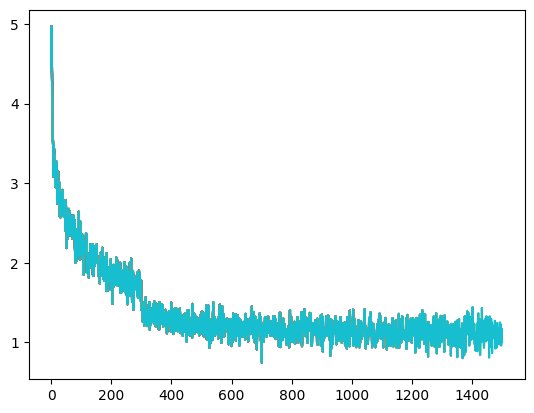

In [50]:
fc3_weights = model_memetic.fc3.weight.data
weights_dim = fc3_weights.shape
weights_len = len(fc3_weights.reshape(-1))
fc3_bias = model_memetic.fc3.bias.data
bias_dim = fc3_bias.shape
bias_len = len(fc3_bias.reshape(-1))
populationSize  = 100
dimension = weights_len + bias_len

# Freeze all layers except the last
freeze_all_but_last(model_memetic)
if "Particle" in dir(creator):
    del creator.Particle
elif "FitnessMin" in dir(creator):
    del creator.FitnessMin


# DEAP inits
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list,
                smin=None, smax=None, best=None, potential=None)

toolbox = base.Toolbox()
toolbox.register("particle", generate_particle, dimension)
toolbox.register("population", tools.initRepeat, list, toolbox.particle)
toolbox.register("evaluate", evaluate_particle)
toolbox.register("learn", behaviour_learning)

# Model hyperparameters
dropout_prob = 0.30
num_epochs = 5
batch_size = 128

memtic_loss = None
memtic_accuracy = None
fits_memetic = []

# call function
# Main loop for k-fold cross-validation
for fold, (train_fold_indices, val_fold_indices) in enumerate(skf.split(train_idx, stratified_train_labels)):
    print(f'Fold {fold + 1}/{num_folds}')
    mean, std = calc_mean_std(Subset(stratified_train_set, train_fold_indices))

    train_sampler = torch.utils.data.SubsetRandomSampler(train_fold_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_fold_indices)

    # create an initial population of individuals
    pop = toolbox.population(n=populationSize)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)


    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields

    train_loader = torch.utils.data.DataLoader(
        dataset=stratified_train_set,
        batch_size=batch_size,
        sampler=train_sampler,
        worker_init_fn=seed_worker,
        generator=g)

    val_loader = torch.utils.data.DataLoader(
        dataset=stratified_train_set,
        batch_size=batch_size,
        sampler=val_sampler,
        worker_init_fn=seed_worker,
        generator=g)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_memetic.parameters(), lr=0.001)

    model_memetic, memetic_loss, memetic_accuracy = memetic_train_and_validate(model_memetic, toolbox, pop, train_loader, val_loader, criterion, optimizer, mean, std, fits_memetic, epochs=num_epochs)
    break

### Test Model

In [51]:
# test model
print("Memetic:")
test(model_memetic, test_loader, mean, std)

Memetic:
Test Accuracy: 65.43%


### Save Loss, Accuracy & Fitness Curves

In [56]:
memetic_stats = {"loss": memetic_loss, "accuracy": memetic_accuracy, "fits": fits_memetic}

df_memetic = pd.DataFrame(memetic_stats)

df_memetic.to_csv('models/memetic/stats/loss_acc.csv', index=False, header=False )

In [57]:
# save population to csv
with open('population.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for individual in pop:
        writer.writerow(individual)  # Write the individual's attributes

In [59]:
with open('logbook.csv', 'w', newline='') as csvfile:
    # If logbook entries are dictionaries, get the keys for column headers
    if logbook:
        headers = list(logbook[0].keys())
        writer = csv.DictWriter(csvfile, fieldnames=headers)
        writer.writeheader()
        for entry in logbook:
            writer.writerow(entry)

# Plots

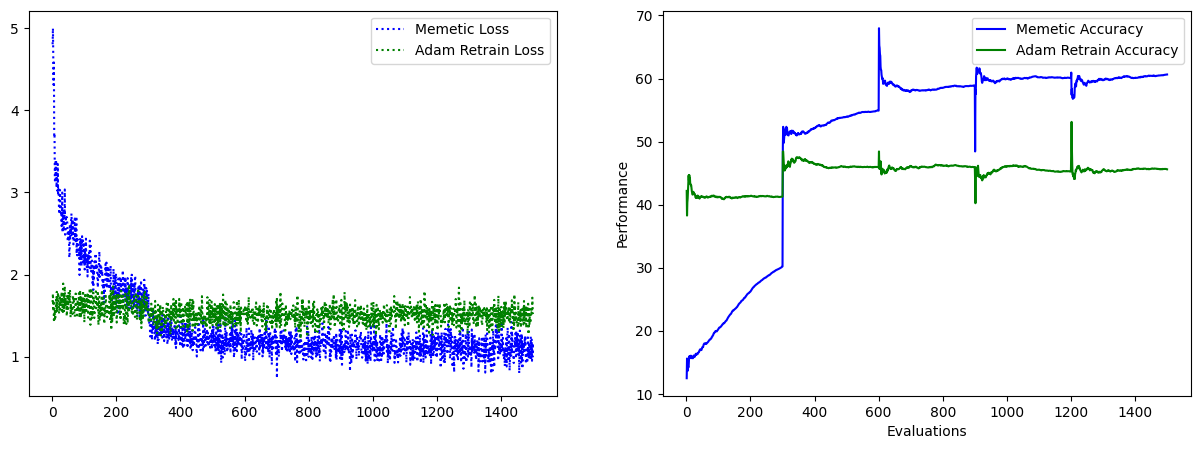

In [64]:
memetic_fig = plt.figure(figsize=(15,5))

# First subplot
loss_plot_memetic = memetic_fig.add_subplot(121)

# Second subplot
acc_plot_memetic = memetic_fig.add_subplot(122)

# Example data
epochs = list(range(1, 1501))  # Replace with your actual x-axis values

# Plotting
acc_plot_memetic.plot(epochs, memetic_accuracy, color='blue', linestyle='-', label='Memetic Accuracy')
acc_plot_memetic.plot(epochs, adam_retrain_accuracy, color='green', linestyle='-', label='Adam Retrain Accuracy')
loss_plot_memetic.plot(epochs, memetic_loss, color='blue', linestyle=':', label='Memetic Loss')
loss_plot_memetic.plot(epochs, adam_retrain_loss, color='green', linestyle=':', label='Adam Retrain Loss')

# Labeling Axes
plt.xlabel('Evaluations')
plt.ylabel('Performance')

# Adding a Legend
acc_plot_memetic.legend()
loss_plot_memetic.legend()

# Show the plot
plt.show()

# Results & Comparisons

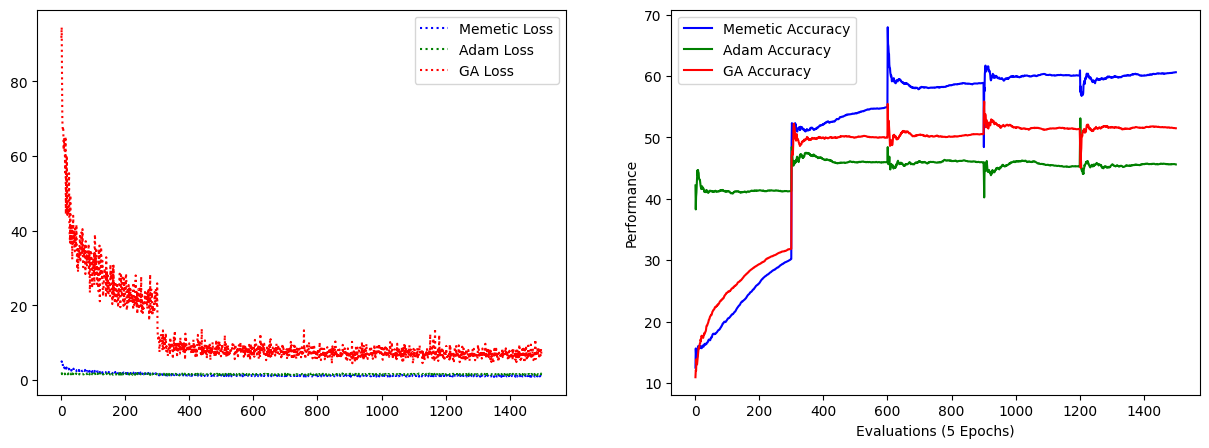

In [76]:
final_fig = plt.figure(figsize=(15,5))

# First subplot
loss_plot_final = final_fig.add_subplot(121)

# Second subplot
acc_plot_final = final_fig.add_subplot(122)

# Example data
epochs = list(range(1, 1501))  # Replace with your actual x-axis values

# Plotting
acc_plot_final.plot(epochs, memetic_accuracy[::], color='blue', linestyle='-', label='Memetic Accuracy')
acc_plot_final.plot(epochs, adam_retrain_accuracy[::], color='green', linestyle='-', label='Adam Accuracy')
loss_plot_final.plot(epochs, memetic_loss[::], color='blue', linestyle=':', label='Memetic Loss')
loss_plot_final.plot(epochs, adam_retrain_loss[::], color='green', linestyle=':', label='Adam Loss')
acc_plot_final.plot(epochs, ga_accuracy[::], color='red', linestyle='-', label='GA Accuracy')
loss_plot_final.plot(epochs, ga_loss[::], color='red', linestyle=':', label='GA Loss')


# Labeling Axes
plt.xlabel('Evaluations (5 Epochs)')
plt.ylabel('Performance')

# Adding a Legend
acc_plot_final.legend()
loss_plot_final.legend()

# Show the plot
plt.show()

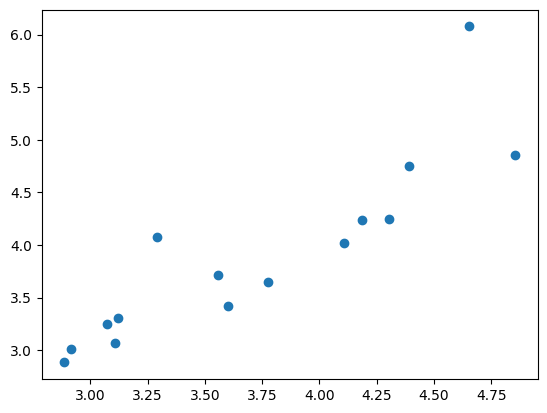